In [ ]:
!pip install numpy --upgrade

In [ ]:
import numpy as np
import pandas as pd

!pip install -q tf-models-official
!pip install category_encoders

import spacy
import nltk
import string
import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Datasets/train.csv', index_col='id')
test_df = pd.read_csv('/content/drive/MyDrive/Datasets/test.csv', index_col='id')
submission = pd.read_csv('/content/drive/MyDrive/Datasets/sample_submission.csv')

print(f'Training Set Shape = {train_df.shape}')
print(f'Test Set Shape = {test_df.shape}')

Training Set Shape = (7613, 4)
Test Set Shape = (3263, 3)


In [ ]:
train_df

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [ ]:
train_df['keyword'] = train_df['keyword'].fillna('none')

In [ ]:
from category_encoders import WOEEncoder

woe = WOEEncoder(drop_invariant=True, randomized = True)
woe.fit(train_df['keyword'], train_df['target'])
X = woe.transform(train_df['keyword'])
X['target'] = train_df['target']
X

,keyword,target
id,,
1,1.048556,1
4,1.048556,1
5,1.048556,1
6,1.048556,1
7,1.048556,1
...,...,...
10869,1.048556,1
10870,1.048556,1
10871,1.048556,1


In [ ]:
train_df['keyword'] = X['keyword']
test_df['keyword'] = woe.transform(test_df['keyword'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cols = ['keyword']

scaler = MinMaxScaler()

train_df[cols] = scaler.fit_transform(train_df[cols])
test_df[cols] = scaler.transform(test_df[cols])

In [ ]:
train_df

,keyword,location,text,target
id,,,,
1,0.59645,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,0.59645,NaN,Forest fire near La Ronge Sask. Canada,1
5,0.59645,NaN,All residents asked to 'shelter in place' are ...,1
6,0.59645,NaN,"13,000 people receive #wildfires evacuation or...",1
7,0.59645,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,0.59645,NaN,Two giant cranes holding a bridge collapse int...,1
10870,0.59645,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,0.59645,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [ ]:
spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')
sp = spacy.load('en_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt')

spacy_st = nlp.Defaults.stop_words
nltk_st = stopwords.words('english')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
spacy.cli.download("es_core_news_sm")
nlp = spacy.load('es_core_news_sm')
sp = spacy.load('es_core_news_sm')

nltk.download('stopwords')
nltk.download('punkt')

spacy_st = nlp.Defaults.stop_words
nltk_st = stopwords.words('spanish')

In [ ]:
def clean_text(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons/ifadeler
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs/semboller ve piktograflar
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols/ulaşım ve harita sembolleri
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)/bayraklar (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',text)

    text = text.replace('#',' ')
    text = text.replace('@',' ')
    symbols = re.compile(r'[^A-Za-z0-9 ]')
    text = symbols.sub(r'',text)

    return text

In [ ]:
def clean(text, http=True, punc=True, lem=True, stop_w=True):
    if http == True:
        text = re.sub('https?:\/\/t.co\/[A-Za-z0-9]*', '', text)
    if stop_w == True:
        text = [word for word in word_tokenize(text) if not word.lower() in nltk_st]
        text = ' '.join(text)
    if lem == True:
        lemmatized = [word.lemma_ for word in sp(text)]
        text = ' '.join(lemmatized)
    if punc == True:
        text = text.translate(str.maketrans('', '', string.punctuation))

    text = text.lower()
    text = text.strip(' ')

    return text

In [ ]:
train_df['cleaned_text'] = train_df['text'].apply(lambda text: clean(text, http=True, punc=True, lem=True, stop_w=False))
test_df['cleaned_text'] = test_df['text'].apply(lambda text: clean(text, http=True, punc=True, lem=True, stop_w=False))
train_df.drop(columns=['text'], axis=1, inplace=True)
test_df.drop(columns=['text'], axis=1, inplace=True)
train_df.head(3)

,keyword,location,target,cleaned_text
id,,,,
1,0.59645,NaN,1,our deed be the reason of this earthquake may...
4,0.59645,NaN,1,forest fire near la ronge sask canada
5,0.59645,NaN,1,all resident ask to shelter in place be be n...


In [ ]:
train_df = train_df.rename(columns={'cleaned_text':'text'})
test_df = test_df.rename(columns={'cleaned_text':'text'})

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
    #input2 = tf.keras.layers.Input(shape=1, name='input2')
    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/2", trainable=True)
    outputs = encoder(encoder_inputs)
    pooled_output = outputs["pooled_output"]      # [batch_size, 768].
    net1 = tf.keras.layers.Dropout(0.1)(pooled_output)
    net2 = tf.keras.layers.Dense(5, activation='relu')(net1)
    #concat = tf.keras.layers.Concatenate()([net2, input2])
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net1)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
X = train_df[["text"]]
y = train_df.target

In [ ]:
X

,text
id,
1,our deed be the reason of this earthquake may...
4,forest fire near la ronge sask canada
5,all resident ask to shelter in place be be n...
6,13000 people receive wildfire evacuation orde...
7,just got send this photo from ruby alaska as ...
...,...
10869,two giant crane hold a bridge collapse into ne...
10870,ariaahrary thetawniest the out of control wild...
10871,m194 0104 utc5 km s of volcano hawaii


In [ ]:
y

id
1        1
4        1
5        1
6        1
7        1
        ..
10869    1
10870    1
10871    1
10872    1
10873    1
Name: target, Length: 7613, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def get_model():

    model = build_classifier_model()

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    metrics = tf.metrics.BinaryAccuracy()

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=0.00001,
                    decay_steps=100,
                    decay_rate=0.5)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

    return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

models = []
preds = []

epochs = 10

n_folds = 2
repeats = 1

#k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

#for train_index, test_index in k_fold.split(X, y):
#    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

model = get_model()

history = model.fit(
      X_train, y_train,
      validation_data=(X_test, y_test),
      epochs=epochs,
      callbacks=[early_stopping]
      )
models.append(model)
preds.append(model.predict(test_df.text))

Epoch 1/10
191/191 [==============================] - 178s 730ms/step - loss: 0.4802 - binary_accuracy: 0.7800 - val_loss: 0.4319 - val_binary_accuracy: 0.8083
Epoch 2/10
191/191 [==============================] - 132s 689ms/step - loss: 0.3965 - binary_accuracy: 0.8294 - val_loss: 0.4199 - val_binary_accuracy: 0.8221
Epoch 3/10
191/191 [==============================] - 140s 733ms/step - loss: 0.3793 - binary_accuracy: 0.8402 - val_loss: 0.4181 - val_binary_accuracy: 0.8240
Epoch 4/10
191/191 [==============================] - 132s 691ms/step - loss: 0.3730 - binary_accuracy: 0.8425 - val_loss: 0.4178 - val_binary_accuracy: 0.8240
Epoch 5/10
191/191 [==============================] - 140s 731ms/step - loss: 0.3757 - binary_accuracy: 0.8374 - val_loss: 0.4177 - val_binary_accuracy: 0.8240
Epoch 6/10
191/191 [==============================] - 140s 731ms/step - loss: 0.3744 - binary_accuracy: 0.8433 - val_loss: 0.4176 - val_binary_accuracy: 0.8240
Epoch 7/10
191/191 [====================

In [ ]:
pd.DataFrame(history.history)

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.480161,0.779967,0.431861,0.808273
1,0.396498,0.829392,0.419867,0.822062
2,0.379262,0.840230,0.418110,0.824032
3,0.373016,0.842529,0.417768,0.824032
4,0.375705,0.837438,0.417679,0.824032
5,0.374379,0.843350,0.417648,0.824032
6,0.376340,0.842857,0.417641,0.824032
7,0.373349,0.841872,0.417641,0.824032
8,0.375206,0.841379,0.417640,0.824032
9,0.373681,0.841708,0.417640,0.824032


<Axes: >

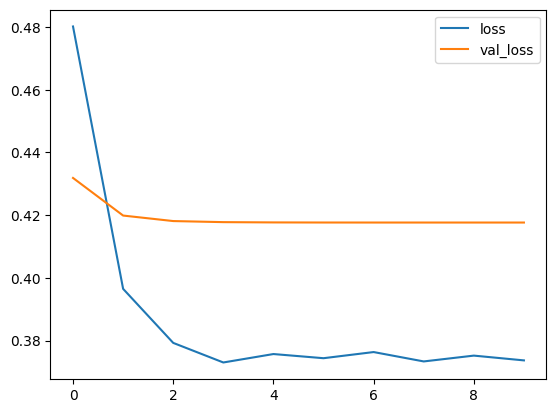

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

<Axes: >

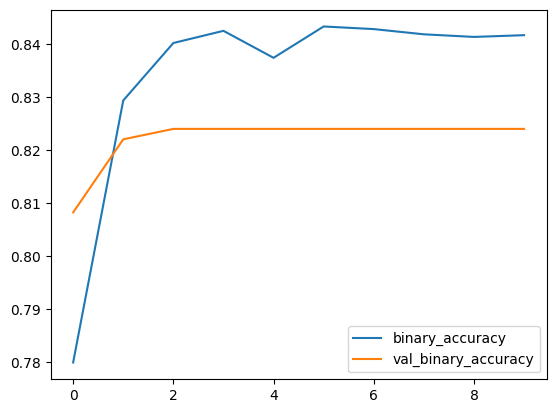

In [ ]:
pd.DataFrame(history.history)[['binary_accuracy', 'val_binary_accuracy']].plot()

In [ ]:
pred = np.average(np.array(preds), axis=0)
print(pred)

[[0.84057003]
 [0.87881315]
 [0.91399723]
 ...
 [0.96638304]
 [0.964406  ]
 [0.6772556 ]]


In [ ]:
pred = np.round(pred.T[0])

<Axes: >

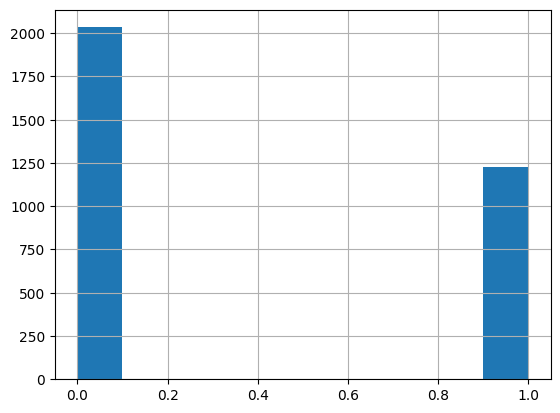

In [ ]:
pd.Series(pred).hist()

In [ ]:
submission.target = pred.astype('int')
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
submission.to_csv('/content/drive/MyDrive/Datasets/submission.csv', index=False)

In [ ]:
tweets_df = pd.read_csv('/content/drive/MyDrive/Datasets/tweets_en.csv', index_col='id', encoding='latin-1')
tweets_submission = pd.read_csv('/content/drive/MyDrive/Datasets/tweets_submission.csv')

In [ ]:
tweets_df

,date,user,text
id,,,
0,2023-02-28 23:26:00+00:00,Traffic_ZMG,Collapsed traffic from Zapopan Centro Cemetery...
1,2023-02-28 23:18:00+00:00,Traffic_ZMG,Motorcyclist hit from the rear by a vehicle in...
2,2023-02-28 21:28:24+00:00,Traffic_ZMG,"They are operating in Tlajomulco, they join th..."
3,2023-02-28 21:26:40+00:00,Traffic_ZMG,Traffic completely stopped on the Nogales high...
4,2023-02-28 21:20:27+00:00,Traffic_ZMG,"Nurses ask to clarify the death of Esmeralda, ..."
...,...,...,...
7995,2022-11-17 17:21:03+00:00,Traffic_ZMG,Attention @AgenciaAMIM
7996,2022-11-17 16:42:40+00:00,Traffic_ZMG,Collision between a public transport unit and ...
7997,2022-11-17 16:18:24+00:00,Traffic_ZMG,Road mishap on Independencia road and Madero s...


In [ ]:
predictions = model.predict(tweets_df.text)

250/250 [==============================] - 63s 254ms/step


In [ ]:
print(predictions)
predictions = np.round(predictions.T[0])

[[0.62247163]
 [0.89544225]
 [0.39413112]
 ...
 [0.48042628]
 [0.6194816 ]
 [0.97361493]]


In [ ]:
tweets_submission.target = predictions.astype('int')

In [ ]:
tweets_submission.to_csv('/content/drive/MyDrive/Datasets/predictions.csv', index=False)

In [ ]:
model.save('/content/drive/MyDrive/Models/BERT_Encoder/BERT_Model.h5')